In [2]:
!pip install --pre deepchem[torch]

DEPRECATION: Loading egg at c:\users\charb\appdata\local\programs\python\python311\lib\site-packages\absl_py-2.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\charb\appdata\local\programs\python\python311\lib\site-packages\albumentations-1.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\charb\appdata\local\programs\python\python311\lib\site-packages\blinker-1.6.3-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\ch

In [5]:
import deepchem as dc
import pandas as pd
import selfies as sf
import numpy as np
import torch
from rdkit import Chem
import matplotlib.pyplot as plt


In [4]:
# Download from MolNet
tasks, datasets, transformers = dc.molnet.load_qm9(featurizer='ECFP')
df = pd.DataFrame(data={'smiles': datasets[0].ids})

In [5]:
data = df[['smiles']].sample(2500, random_state=42)

In [6]:
sf.set_semantic_constraints()  # reset constraints
constraints = sf.get_semantic_constraints()
constraints['?'] = 3

sf.set_semantic_constraints(constraints)
constraints

{'H': 1,
 'F': 1,
 'Cl': 1,
 'Br': 1,
 'I': 1,
 'B': 3,
 'B+1': 2,
 'B-1': 4,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'N': 3,
 'N+1': 4,
 'N-1': 2,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'P': 5,
 'P+1': 6,
 'P-1': 4,
 'S': 6,
 'S+1': 7,
 'S-1': 5,
 '?': 3}

In [7]:
def preprocess_smiles(smiles):
  return sf.encoder(smiles)  

def keys_int(symbol_to_int):
  d={}
  i=0
  for key in symbol_to_int.keys():
    d[i]=key
    i+=1
  return d

data['selfies'] = data['smiles'].apply(preprocess_smiles)

In [8]:
data['len'] = data['smiles'].apply(lambda x: len(x))
data.sort_values(by='len').head()

,smiles,selfies,len
95023,[H]c1nnoc1[H],[H][C][N][=N][O][C][=Ring1][Branch1][H],13
89066,[H]C#CC([H])=O,[H][C][#C][C][Branch1][C][H][=O],14
575,[H]c1nc(=O)onc1F,[H][C][=N][C][=Branch1][C][=O][O][N][=C][Ring1...,16
55870,[H]C#Cc1nnoc(=O)n1,[H][C][#C][C][N][=N][O][C][=Branch1][C][=O][N]...,18
23420,[H]Oc1nc(=O)nc(F)o1,[H][O][C][=N][C][=Branch1][C][=O][N][=C][Branc...,19


In [9]:
selfies_list = np.asanyarray(data.selfies)
selfies_alphabet = sf.get_alphabet_from_selfies(selfies_list)
selfies_alphabet.add('[nop]')  # Add the "no operation" symbol as a padding character
selfies_alphabet.add('.') 
selfies_alphabet = list(sorted(selfies_alphabet))
largest_selfie_len = max(sf.len_selfies(s) for s in selfies_list)
symbol_to_int = dict((c, i) for i, c in enumerate(selfies_alphabet))
int_mol=keys_int(symbol_to_int)

In [10]:
onehots=sf.batch_selfies_to_flat_hot(selfies_list, symbol_to_int,largest_selfie_len)

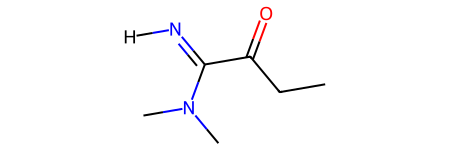

In [11]:
Chem.MolFromSmiles(np.asanyarray(data.smiles)[3])

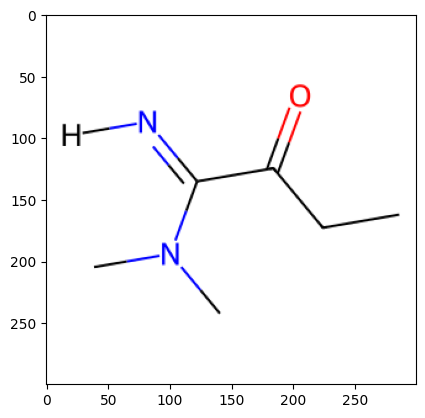

In [12]:
input_tensor = torch.tensor(onehots, dtype=torch.float32)
noise_tensor = torch.rand(input_tensor.shape, dtype=torch.float32)
dequantized_data = input_tensor + noise_tensor

normalized_data = (dequantized_data - dequantized_data.min()) / (dequantized_data.max() - dequantized_data.min())

denormalize_data = normalized_data * (dequantized_data.max() - dequantized_data.min()) + dequantized_data.min()

original_data = torch.floor(denormalize_data)
original_data = torch.clip(original_data, 0, 1)

mols_list = original_data.numpy().tolist()
# Add padding characters if needed
for mol in mols_list:
    for i in range(largest_selfie_len):
        row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
    if all(elem == 0 for elem in row):
        mol[len(selfies_alphabet) * (i+1) - 1] = 1

#print("Input:")
#print(input_tensor[1])
selfies_input = sf.batch_flat_hot_to_selfies(input_tensor.int().tolist(), int_mol)
#print(selfies_input[1])
mol = Chem.MolFromSmiles(sf.decoder(selfies_input[3]))
mol_img = Chem.Draw.MolToImage(mol,size=(300,300))
#plt.imshow(mol_img)

#print("Recontructed:")
#print(original_data[1])
selfies_original = sf.batch_flat_hot_to_selfies(mols_list, int_mol)
mol = Chem.MolFromSmiles(sf.decoder(selfies_original[3]))
mol_img = Chem.Draw.MolToImage(mol,size=(300,300))
plt.imshow(mol_img)
#print(dequantized_data.min())
#print(dequantized_data.max())
#print(dequantized_data[1])

In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#print(largest_selfie_len)
#print(selfies_alphabet)
#print(len(selfies_alphabet))

# debug padding
mols_list = original_data[1:2].int().tolist()
# Add padding characters if needed
for mol in mols_list:
    #print(mol)
    for i in range(largest_selfie_len):
        row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
        print()
        print(row)
    if all(elem == 0 for elem in row):
        mol[len(selfies_alphabet) * (i+1) - 1] = 1


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
print(Chem.Descriptors.MolWt(Chem.MolFromSmiles(smiles)))
print(Chem.Descriptors.MolLogP(Chem.MolFromSmiles(smiles)))
print(Chem.QED.default(Chem.MolFromSmiles(smiles)))

180.15899999999996
1.3101
0.5501217966938848


In [27]:
tasks, datasets, transformers = dc.molnet.load_pcba(featurizer='ECFP', reload=True)
train_dataset, valid_dataset, test_dataset = datasets

[00:59:26] WARNING: not removing hydrogen atom without neighbors
[01:00:31] WARNING: not removing hydrogen atom without neighbors
[01:03:49] WARNING: not removing hydrogen atom without neighbors
[01:04:33] WARNING: not removing hydrogen atom without neighbors
[01:08:03] WARNING: not removing hydrogen atom without neighbors
[01:08:31] WARNING: not removing hydrogen atom without neighbors
[01:10:21] WARNING: not removing hydrogen atom without neighbors
[01:10:44] WARNING: not removing hydrogen atom without neighbors


In [1]:
train_dataset.get_data_shape
#train_dataset.X[2]
#train_dataset.y[2]
#train_dataset.w[2]

NameError: name 'train_dataset' is not defined

In [2]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("jxie/guacamol")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1273104 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/79568 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/238706 [00:00<?, ? examples/s]

In [18]:
#print(dataset['train'][1]['text'])
molswt = [Chem.Descriptors.MolWt(Chem.MolFromSmiles(data['text'])) for data in dataset['train']]
#print(Chem.Descriptors.MolWt(Chem.MolFromSmiles(dataset['train'][1]['text'])))
#print(Chem.Descriptors.MolLogP(Chem.MolFromSmiles(dataset['train'][1]['text'])))
#print(Chem.QED.default(Chem.MolFromSmiles(dataset['train'][1]['text'])))

In [22]:
print(molswt[3])

360.40300000000013
